# Table of Contents
### 01: Import Libraries and Data
### 02: Subsetting, Wrangling, & Cleaning Time Series Data 
### 03: Time Series Analysis: Decomposition
### 04: Testing for Stationarity
### 05: Stationarizing the Housing Data

# 01. Import Data and Libraries

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
#configure API key and import the Zillow Real Estate data
quandl.ApiConfig.api_key = 'RxNBoHBXtywjVQDen6gr'
data = quandl.get_table('ZILLOW/DATA',indicator_id='ZSFH', region_id='99999')

In [3]:
data.head()

,indicator_id,region_id,date,value
None,,,,
0,ZSFH,99999,2023-10-31,481844.413421
1,ZSFH,99999,2023-09-30,484966.561607
2,ZSFH,99999,2023-08-31,487634.068058
3,ZSFH,99999,2023-07-31,489132.669384
4,ZSFH,99999,2023-06-30,489175.037729


In [4]:
df = data[["date", "value"]]

In [5]:
df.shape

(226, 2)

In [6]:
df.columns

Index(['date', 'value'], dtype='object')

In [7]:
df.head()

,date,value
None,,
0,2023-10-31,481844.413421
1,2023-09-30,484966.561607
2,2023-08-31,487634.068058
3,2023-07-31,489132.669384
4,2023-06-30,489175.037729


In [8]:
type(df)

pandas.core.frame.DataFrame

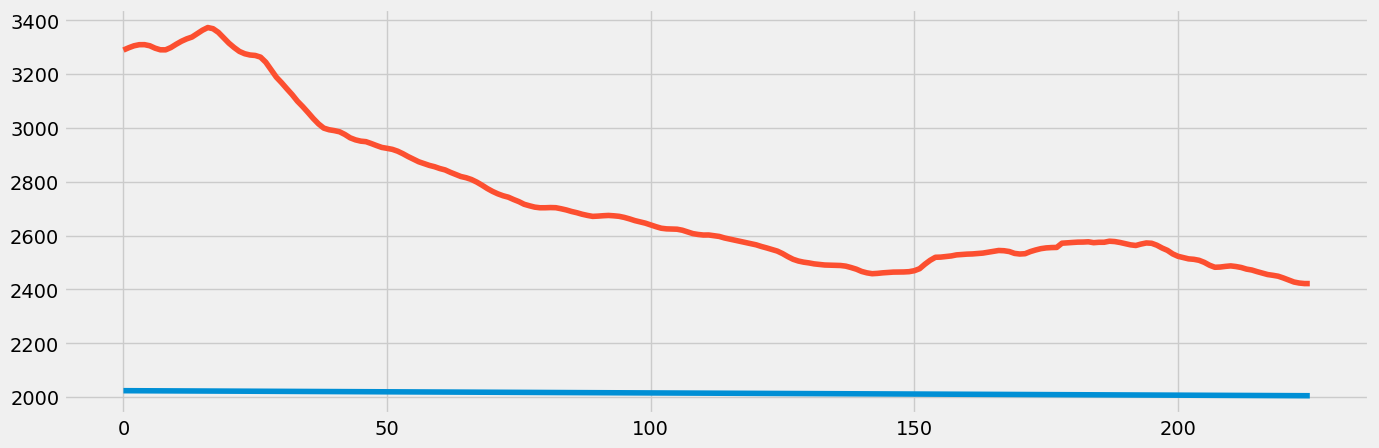

In [9]:
#plot the data using matplotlib

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df)

# 02. Subsetting, Wrangling, & Cleaning Time Series Data

In [10]:
#reset index so that you can use the "Date" column as a filter
df2 = df.reset_index()

In [11]:
df2.drop(['None'], axis=1, inplace=True)

In [12]:
df2.head()

,date,value
0,2023-10-31,481844.413421
1,2023-09-30,484966.561607
2,2023-08-31,487634.068058
3,2023-07-31,489132.669384
4,2023-06-30,489175.037729


In [13]:
# Set the "Date" column as the index
from datetime import datetime
df2['datetime'] = pd.to_datetime(df2['date']) # Create a datetime column from "Date.""
df2 = df2.set_index('datetime') # Set the datetime as the index of the dataframe.
df2.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
df.head()

,date,value
None,,
0,2023-10-31,481844.413421
1,2023-09-30,484966.561607
2,2023-08-31,487634.068058
3,2023-07-31,489132.669384
4,2023-06-30,489175.037729


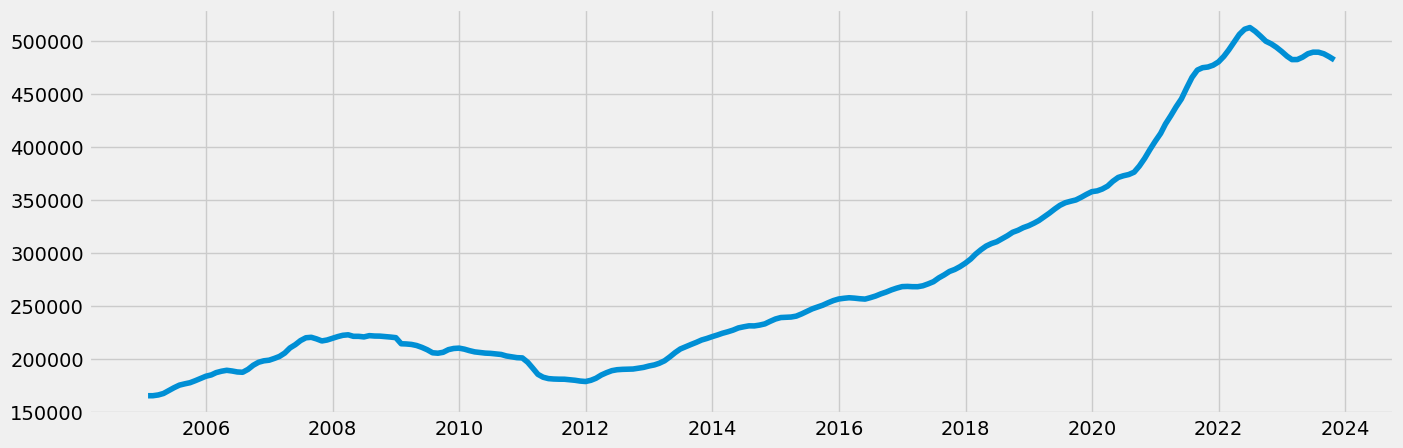

In [14]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df2)

In [15]:
#check for missing values
df2.isnull().sum() 

value    0
dtype: int64

No missing values.

In [16]:
#check for duplicates
dups = df2.duplicated()
dups.sum()

0

No duplicates.

# 03. Time Series Analysis: Decomposition

In [17]:
#decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(df2, model='additive')

In [18]:
from pylab import rcParams #this will define a fixed size for all special charts.
rcParams['figure.figsize'] = 18, 7

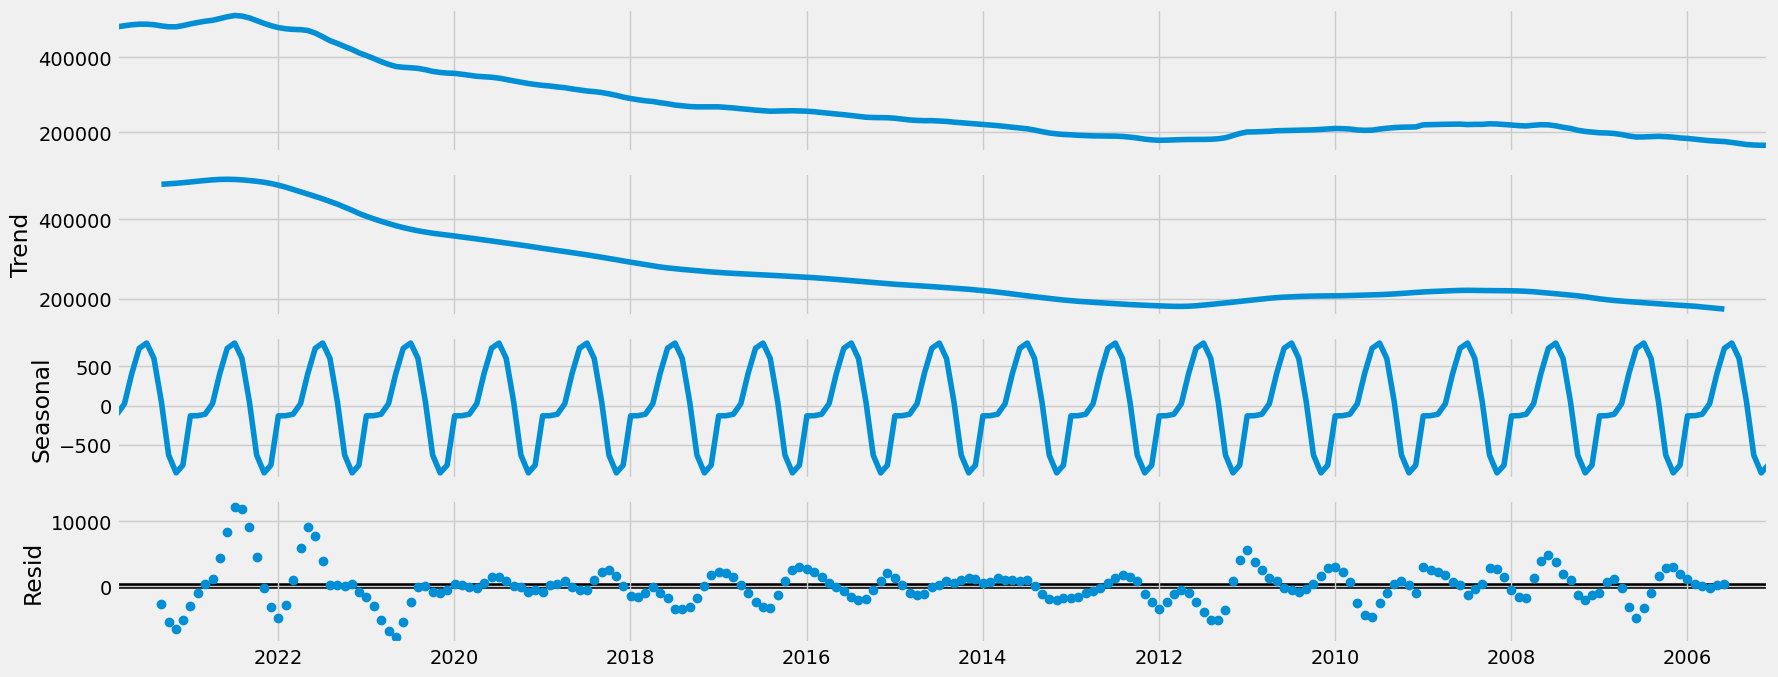

In [19]:
#plot the separate components
decomposition.plot()
plt.show()

From the graph we can see that there has been a gradual increase in price over the years, with only a small drop in prices around 2011. 

# 04. Testing for Stationarity

In [20]:
#perform the Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries):
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

#apply the test using the function on the time series
dickey_fuller(df2['value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.368236
p-value                          0.150903
Number of Lags Used              4.000000
Number of Observations Used    221.000000
Critical Value (1%)             -3.460291
Critical Value (5%)             -2.874709
Critical Value (10%)            -2.573789
dtype: float64


Our test statistic of -2.37 is larger than our critical value (5%) of -2.87, so we cannot reject our null hypothesis.

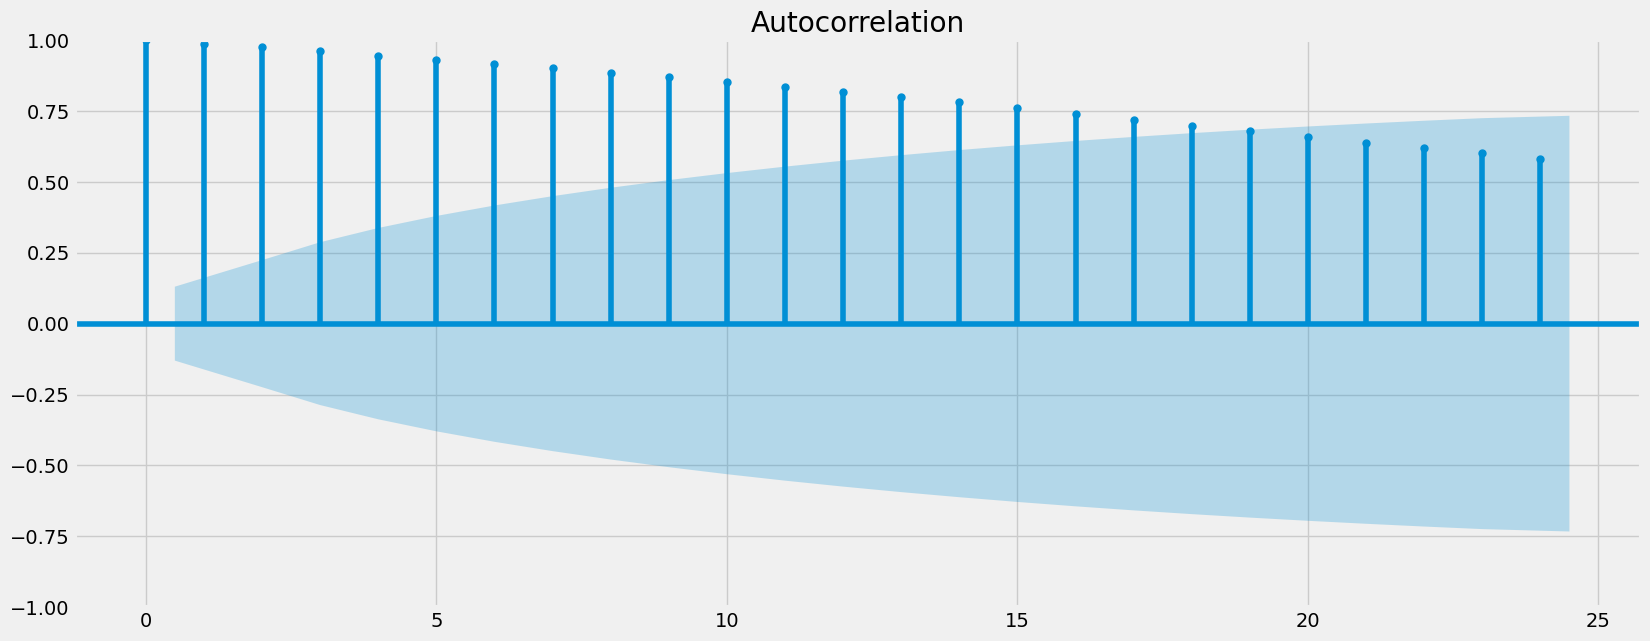

In [21]:
#check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df2)
plt.show()

Based on the autocorrelation chart, there are many lags beyond the blue confidence interval area which shows that our data is not stationary.

# 05. Stationarizing the Housing Data

In [22]:
#creating the differencing equation
data_diff = df2 - df2.shift(1)

In [23]:
#removing the missing values that came from differencing
data_diff.dropna(inplace = True)

In [24]:
data_diff.head()

,value
datetime,
2023-09-30,3122.148186
2023-08-31,2667.506451
2023-07-31,1498.601326
2023-06-30,42.368346
2023-05-31,-1488.980285


In [25]:
data_diff.columns

Index(['value'], dtype='object')

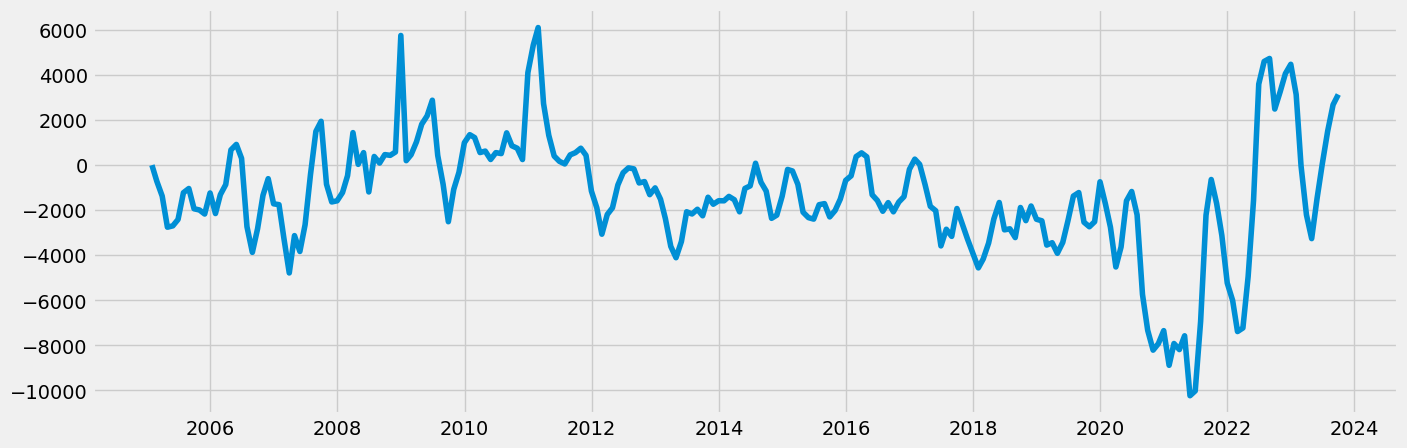

In [26]:
#check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [27]:
#run Dickey-Fuller test on differencing
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.484233
p-value                          0.008401
Number of Lags Used              3.000000
Number of Observations Used    221.000000
Critical Value (1%)             -3.460291
Critical Value (5%)             -2.874709
Critical Value (10%)            -2.573789
dtype: float64


After using the differencing method we can now see that our test statistic of -3.48 is smaller than our critical value (5%) of -2.87, so we can reject our null hypothesis and consider the housing data to be stationary.

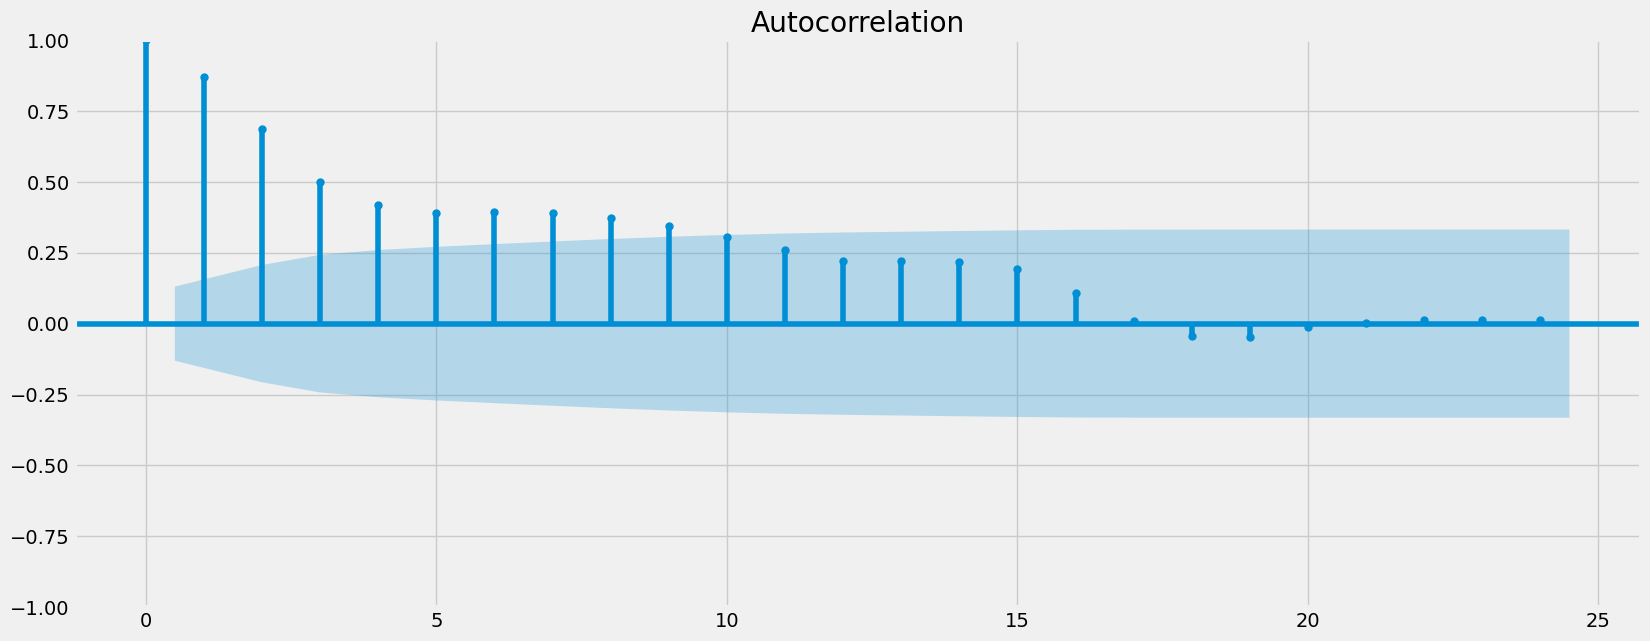

In [28]:
#check autocorrelation
plot_acf(data_diff)
plt.show()

While the autocorrelation plot has improved, the stationarity of this data is weak. 